In [1]:
from pyeosim import datasets
import matplotlib.pyplot as plt
import xarray
import numpy as np
from Py6S import *
# # Create a SixS object called s (used as the standard name by convention)
# s = SixS()
# s.ground_reflectance = GroundReflectance.HomogeneousLambertian(1)
# geom = Geometry.User()
# geom.from_time_and_location(lat=52.04, lon=0.76, datetimestring='2020/06/22T12:00',
#                             view_z=0, view_a=0)
# s.geometry = geom

# s.altitudes.set_sensor_satellite_level()

# # Run the 6S simulation defined by this SixS object across the
# # whole VNIR range
# wavelengths1, results1 = SixSHelpers.Wavelengths.run_wavelengths(s, np.arange(400,900,2)/1000,
#                                                                output_name='pixel_radiance')
# # Plot these results, with the y axis label set to "Pixel Radiance"
# SixSHelpers.Wavelengths.plot_wavelengths(wavelengths1, results1, "Pixel Radiance")
# ref_100 = xarray.DataArray(results1, [('wavelength', wavelengths1*1000)]).interp(
#     wavelength = np.arange(400,900,1)
# ).interpolate_na('wavelength')

# rho = np.arange(0,1,.001)
# output = np.empty(shape=(len(rho), 500))

# for i, _rho in enumerate(rho):
#     _res = ref_100* _rho
#     output[i,:] = _res

# LUT = xarray.DataArray(output,[('rho', rho),('wavelength', np.arange(400,900,1))])
# LUTd = LUT.to_dataset(name='pixel_radiance')
# LUTd.attrs['6S_output_params'] = str(s.outputs.values)
# LUTd.to_netcdf('test2.LUT')

In [2]:
from pyeosim.sensor import LinearCCD
from pyeosim.atmospheric import SixSAtmosphere
from pyeosim.plot import rgb
from pyeosim.measure import RMSE, NDVI

In [3]:
atmos = SixSAtmosphere(LUT_path='test_6s.LUT')
# ccd = LinearCCD()
# ccd.get_params()

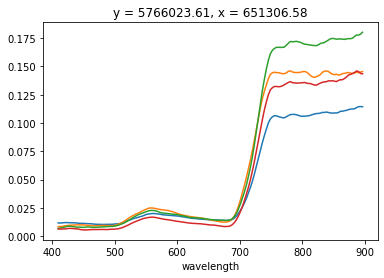

In [4]:
fpath = '../georis/georis/TEST_dataset/TEST collect/TEST-1-20200621/L3_rect/TEST-1-20200622-1_06_VNIR_1800_SN00826_quac_specPol_rectGe.img'
im = xarray.open_rasterio(fpath)
im = im.assign_coords(wavelength=('band',[float(x[:6]) for x in im.descriptions]))
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,899))/10000
im_ref.isel(x=0,y=0).plot()
im_ref.isel(x=0,y=1).plot()
im_ref.isel(x=1,y=0).plot()
im_ref.isel(x=1,y=1).plot()

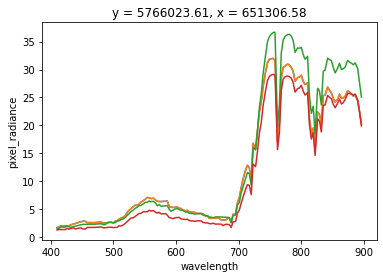

In [5]:
TOA = atmos.transform(im_ref)
TOA.isel(x=0,y=1).plot()
TOA.isel(x=0,y=1).plot()
TOA.isel(x=1,y=0).plot()
TOA.isel(x=1,y=1).plot()

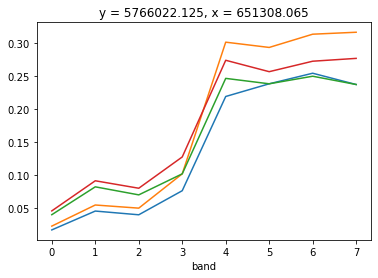

In [9]:
ccd = LinearCCD(integration_time=.1,
                 sense_node_gain=5,
                 dark_noise=10,
                 adc_gain=5000,
                 adc_vref=5,
                 full_well=100000,
                 store_steps=False,
                 ccd_vref=5,
                 psf_fwhm=3,
                 pixel_area = 3,
                 ground_sample_distance=1.5)

ccd.steps_to_latex('CURRENT_STEPS.tex')

ref = atmos.transform(xarray.ones_like(TOA))
out = ccd.transform(TOA)
out_r = out/ccd.transform(ref).mean(['x','y'])
out_r.isel(x=0,y=0).plot()
out_r.isel(x=0,y=1).plot()
out_r.isel(x=1,y=0).plot()
out_r.isel(x=1,y=1).plot()

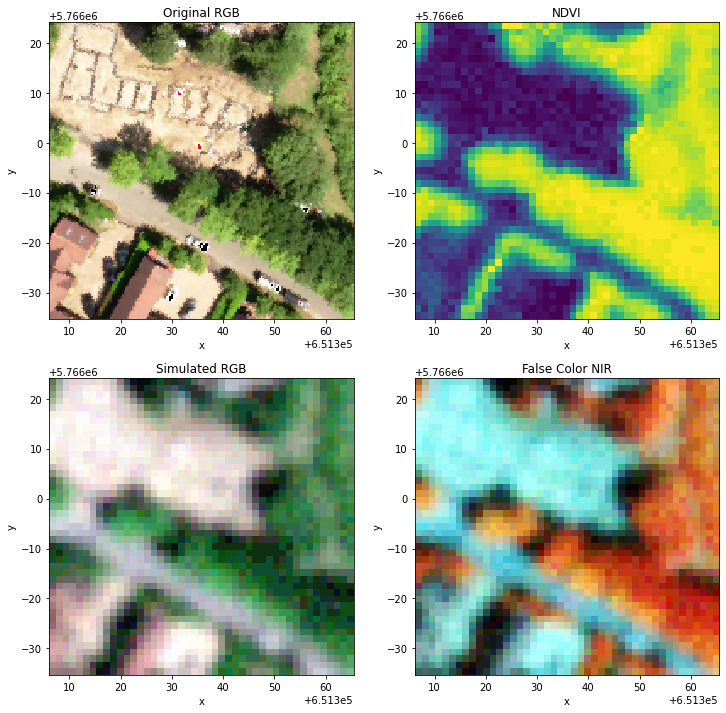

In [10]:
rgb_orig = im.isel(wavelength=[70,40,20]).swap_dims({'wavelength':'band'})
bgr = out.isel(band=[2,1,0])
nir = out.isel(band=[4,1,0])
ndvi = ((out.isel(band=6) - out.isel(band=2))/(out.isel(band=6) + out.isel(band=2)))

fig, ax = plt.subplots(2,2, figsize=(12,12))

rgb(rgb_orig,ax=ax[0][0])
ax[0][0].set_title('Original RGB')

rgb(bgr,ax=ax[1][0])
ax[1][0].set_title('Simulated RGB')

rgb(nir,ax=ax[1][1])
ax[1][1].set_title('False Color NIR')

ndvi.plot(ax=ax[0][1], add_colorbar=False, robust=True)
ax[0][1].set_title('NDVI')

plt.savefig('test_output1.png', dpi=200)

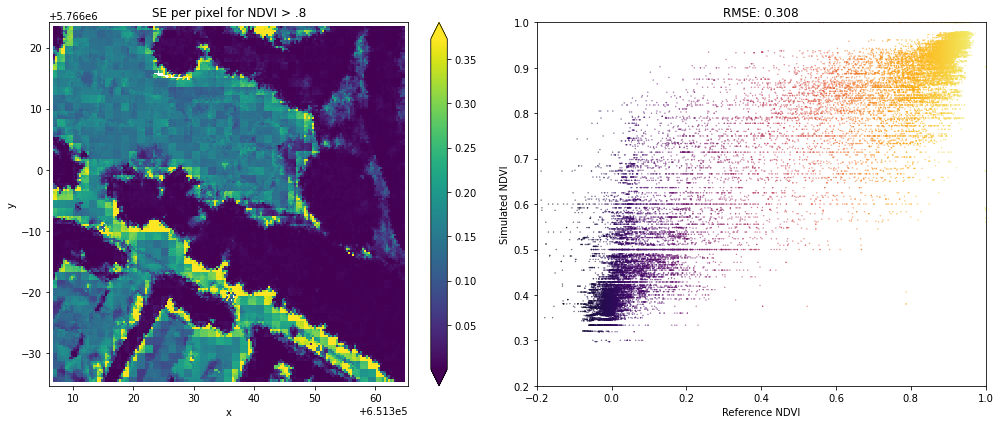

In [11]:
out_interp = out.interp(x=im_ref.x, y=im_ref.y, method='nearest')
ndvi_ref = NDVI(im_ref, min_val=-.2)
ndvi_sim = NDVI(out_interp)

f, ax = plt.subplots(ncols=2, figsize=(14,6))
((ndvi_ref - ndvi_sim)**2).plot(robust=True, ax=ax[0])
ax[0].set_title('SE per pixel for NDVI > .8')
ax[1].scatter(ndvi_ref.stack(pix=['x','y']),
            ndvi_sim.stack(pix=['x','y']), alpha=.9, s=.1,
              c=ndvi_ref.stack(pix=['x','y']),
              cmap='inferno')
ax[1].set_xlabel('Reference NDVI')
ax[1].set_ylabel('Simulated NDVI')
ax[1].set_title('RMSE: {:.3f}'.format(RMSE(ndvi_ref,ndvi_sim)))
ax[1].set_xlim(-.2,1)
ax[1].set_ylim(.2,1)
plt.tight_layout()

plt.savefig('test_output2.png', dpi=200)